100%|██████████| 94.3M/94.3M [00:00<00:00, 207MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Epoch [1/60] | Train Loss: 0.5719, Train Acc: 0.8190 | Val Loss: 0.3082, Val Acc: 0.9000 | Test Acc: 0.8944
Epoch [2/60] | Train Loss: 0.3651, Train Acc: 0.8755 | Val Loss: 0.2589, Val Acc: 0.9107 | Test Acc: 0.9144
Epoch [3/60] | Train Loss: 0.3317, Train Acc: 0.8881 | Val Loss: 0.2433, Val Acc: 0.9237 | Test Acc: 0.9181
Epoch [4/60] | Train Loss: 0.3277, Train Acc: 0.8878 | Val Loss: 0.2493, Val Acc: 0.9170 | Test Acc: 0.9256
Epoch [5/60] | Train Loss: 0.3086, Train Acc: 0.8937 | Val Loss: 0.2285, Val Acc: 0.9211 | Test Acc: 0.9226
Epoch [6/60] | Train Loss: 0.3005, Train Acc: 0.8962 | Val Loss: 0.2326, Val Acc: 0.9256 | Test Acc: 0.9219
Epoch [7/60] | Train Loss: 0.3041, Train Acc: 0.8943 | Val Loss: 0.2551, Val Acc: 0.9170 | Test Acc: 0.9170
Epoch [8/60] | Train Loss: 0.2952, Train Acc: 0.8988 | Val Loss: 0.2336, Val Acc: 0.9226 | Test Acc: 0.9256
Epoch [9/60] | Train Loss: 0.2873, Train Acc: 0.9019 | Val Loss: 0.2144, Val Acc: 0.9307 | Test Acc: 0.9337
Epoch [10/60] | Train Loss: 

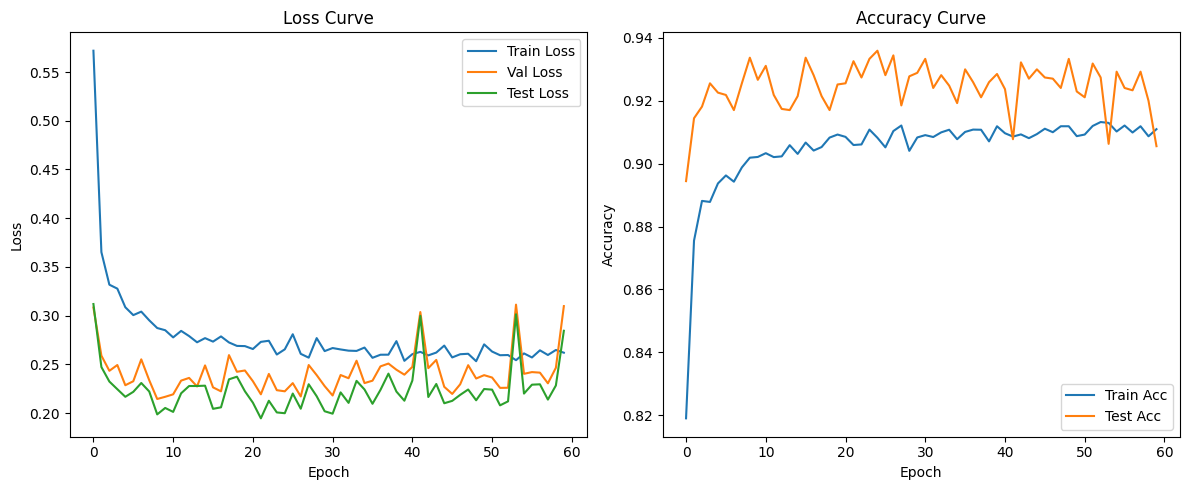


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.84      0.95      0.89       288
              Forest       0.94      0.99      0.97       291
HerbaceousVegetation       0.87      0.94      0.91       301
             Highway       0.92      0.72      0.80       255
          Industrial       0.95      0.92      0.93       253
             Pasture       0.86      0.98      0.91       210
       PermanentCrop       0.97      0.70      0.81       269
         Residential       0.91      0.99      0.95       291
               River       0.83      0.87      0.85       253
             SeaLake       1.00      0.98      0.99       289

            accuracy                           0.91      2700
           macro avg       0.91      0.90      0.90      2700
        weighted avg       0.91      0.91      0.90      2700



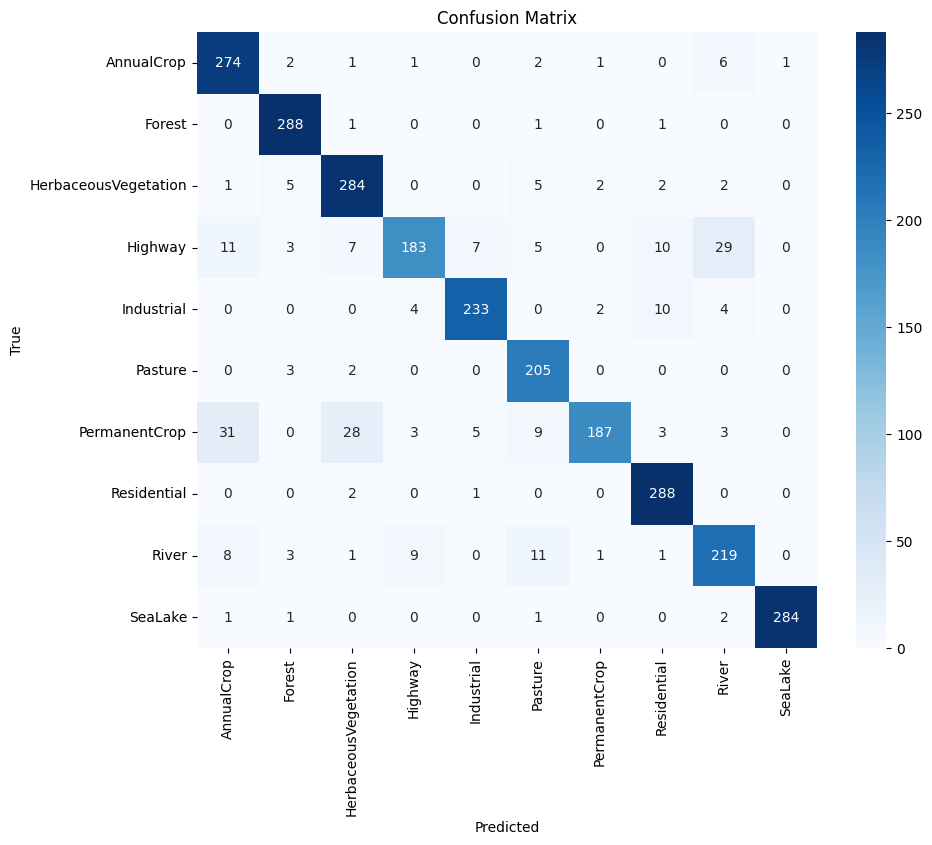

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.EuroSAT(root='./data', transform=transform_train, download=True)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Update transform for val/test
val_ds.dataset.transform = transform_test
test_ds.dataset.transform = transform_test

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for EuroSAT (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Only train the final layer
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 60

train_losses, val_losses = [], []
train_accuracies, test_accuracies, test_losses = [], [], []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)

    # Test
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Test Acc: {test_acc:.4f}")

# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Final test evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()